# 04 — Product Recommendation Engine

> Personalising the shopping experience — a core Boots data science use case.

Three approaches built:
1. **Collaborative Filtering** — 'customers like you also bought'
2. **Content-Based Filtering** — 'similar products to what you've bought'
3. **Hybrid Model** — weighted combination for best performance

This mirrors real-world recommender systems used by Boots, Amazon and Netflix.

In [2]:
import os
os.chdir(r'C:\Users\mohit\Downloads\Boots_Project2')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.insert(0, '.')
from src.data.loader import load_transactions, load_products
from src.data.preprocessor import clean_transactions, add_time_features
from src.models.recommender import CollaborativeFilteringRecommender, ContentBasedRecommender, HybridRecommender
import warnings; warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.dpi': 120, 'axes.spines.top': False, 'axes.spines.right': False})

transactions = load_transactions()
transactions = clean_transactions(transactions)
transactions = add_time_features(transactions)
products     = load_products()

print(f"Transactions: {len(transactions):,}")
print(f"Unique customers: {transactions['customer_id'].nunique():,}")
print(f"Unique products:  {transactions['product_id'].nunique():,}")
print(f"Sparsity of user-item matrix: {1 - len(transactions) / (transactions['customer_id'].nunique() * transactions['product_id'].nunique()):.2%}")


2026-02-19 22:59:49,989 | INFO | src.data.loader | Loading transactions from data/raw/transactions.csv
2026-02-19 22:59:50,512 | INFO | src.data.loader | Loaded 80,000 rows
2026-02-19 22:59:50,642 | INFO | src.data.preprocessor | Cleaned: 80,000 -> 80,000 rows (0 removed)
Transactions: 80,000
Unique customers: 3,469
Unique products:  197
Sparsity of user-item matrix: 88.29%


## Train-Test Split

We hold out the last 30 days of each customer's purchases as a test set — this simulates predicting future purchases from historical behaviour.

In [3]:
# Temporal train/test split
cutoff = transactions['date'].max() - pd.Timedelta(days=30)
train = transactions[transactions['date'] <= cutoff].copy()
test  = transactions[transactions['date'] > cutoff].copy()

print(f"Train: {len(train):,} transactions up to {cutoff.date()}")
print(f"Test : {len(test):,} transactions after {cutoff.date()}")
print(f"Test customers: {test['customer_id'].nunique():,}")


Train: 73,515 transactions up to 2026-01-20
Test : 6,485 transactions after 2026-01-20
Test customers: 1,984


## Collaborative Filtering

Builds a user-item matrix and finds customers with similar purchase histories using cosine similarity.

In [4]:
cf_model = CollaborativeFilteringRecommender(min_interactions=3, n_recommendations=10)
cf_model.fit(train)

# Example recommendations
example_customer = train['customer_id'].value_counts().index[0]  # most active customer
recs_cf = cf_model.recommend(example_customer, n=10)
recs_cf = recs_cf.merge(products[['product_id','product_name','category','price']], on='product_id', how='left')

print(f"\nCollaborative Filtering recommendations for customer: {example_customer}")
print(recs_cf[['product_name','category','price','score']].to_string(index=False))


2026-02-19 22:59:50,953 | INFO | src.models.recommender | Building user-item matrix for collaborative filtering...
2026-02-19 22:59:52,066 | INFO | src.models.recommender | CF model fitted | 2,718 customers | 196 products

Collaborative Filtering recommendations for customer: C04739
product_name   category  price     score
 Product_113   Pharmacy  48.30 62.419172
  Product_24  Fragrance   8.21 53.844058
 Product_183  Fragrance   5.80 49.577698
 Product_185 Electrical   9.33 34.962648
 Product_193   Vitamins  17.05 34.324888
 Product_182       Baby  23.11 29.030831
 Product_154   Skincare  16.81 28.154348
 Product_156  Fragrance   6.22 25.885472
  Product_70   Pharmacy  16.28 24.550915
  Product_65  Fragrance  23.82 22.158337


## Content-Based Filtering

Recommends similar products based on category and price features — useful for new customers with limited history (cold start).

In [5]:
cb_model = ContentBasedRecommender(n_recommendations=10)
cb_model.fit(products)

# Find a popular product and recommend similar
popular_product = transactions.groupby('product_id')['quantity'].sum().idxmax()
product_name = products[products['product_id']==popular_product]['product_name'].values[0]
product_cat  = products[products['product_id']==popular_product]['category'].values[0]

recs_cb = cb_model.recommend_similar(popular_product, n=10)
recs_cb = recs_cb.merge(products[['product_id','product_name','category','price']], on='product_id', how='left')

print(f"\nContent-based recommendations similar to: {product_name} (Category: {product_cat})")
print(recs_cb[['product_name','category','price']].to_string(index=False))


2026-02-19 22:59:52,164 | INFO | src.models.recommender | Building product feature matrix for content-based filtering...
2026-02-19 22:59:52,188 | INFO | src.models.recommender | Content-based model fitted | 200 products

Content-based recommendations similar to: Product_171 (Category: Haircare)
product_name category  price
  Product_90 Haircare  15.27
  Product_66 Haircare  15.51
  Product_18 Haircare  16.15
 Product_110 Haircare  14.14
 Product_162 Haircare  13.86
 Product_197 Haircare  18.35
  Product_91 Haircare  12.43
  Product_64 Haircare  10.75
  Product_85 Haircare   8.22
   Product_8 Haircare   7.29


## Hybrid Recommender

Combines both signals: 70% collaborative filtering + 30% content-based. This is the production model.

In [6]:
hybrid = HybridRecommender(cf_weight=0.7, cb_weight=0.3, n_recommendations=10)
hybrid.fit(train, products)

recs_hybrid = hybrid.recommend(example_customer, last_purchased_product=popular_product)
recs_hybrid = recs_hybrid.merge(products[['product_id','product_name','category','price']], on='product_id', how='left')

print(f"Hybrid recommendations for: {example_customer}")
print(recs_hybrid[['product_name','category','price','score','method']].to_string(index=False))


2026-02-19 22:59:52,287 | INFO | src.models.recommender | Building user-item matrix for collaborative filtering...
2026-02-19 22:59:53,453 | INFO | src.models.recommender | CF model fitted | 2,718 customers | 196 products
2026-02-19 22:59:53,464 | INFO | src.models.recommender | Building product feature matrix for content-based filtering...
2026-02-19 22:59:53,486 | INFO | src.models.recommender | Content-based model fitted | 200 products
Hybrid recommendations for: C04739
product_name   category  price     score method
 Product_113   Pharmacy  48.30 43.693421 hybrid
  Product_24  Fragrance   8.21 37.690841 hybrid
 Product_183  Fragrance   5.80 34.704389 hybrid
 Product_185 Electrical   9.33 24.473854 hybrid
 Product_193   Vitamins  17.05 24.027422 hybrid
 Product_182       Baby  23.11 20.321582 hybrid
 Product_154   Skincare  16.81 19.708044 hybrid
 Product_156  Fragrance   6.22 18.119830 hybrid
  Product_70   Pharmacy  16.28 17.185640 hybrid
 Product_110   Haircare  14.14 15.759373 h

## Recommendation Coverage by Category

Are recommendations diverse, or do they over-represent one category?

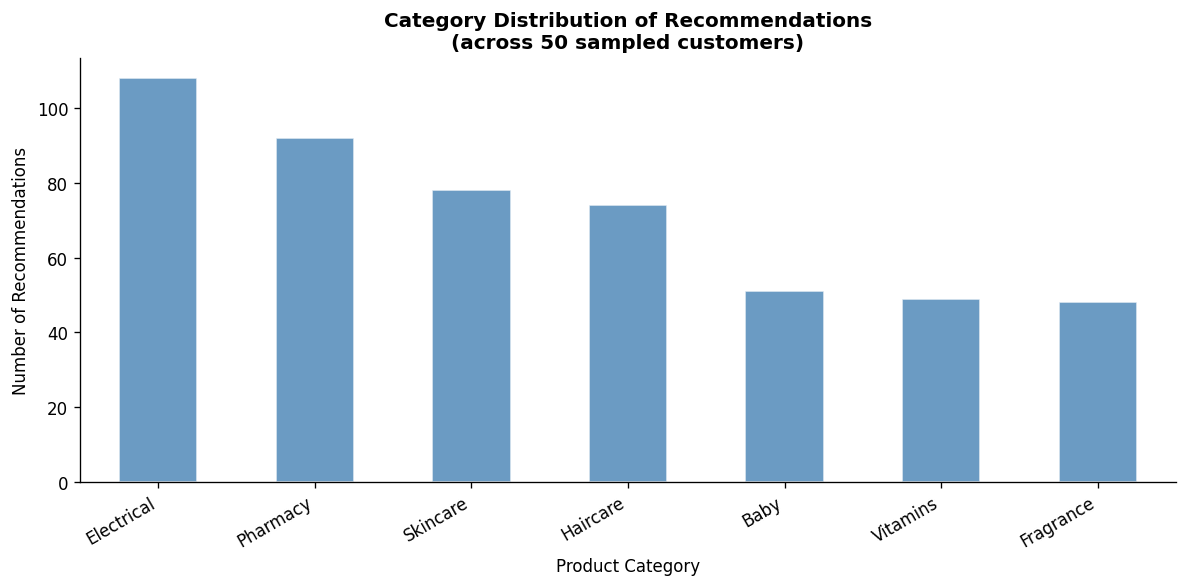

In [7]:
# Sample recommendations across 50 customers
sample_customers = train['customer_id'].value_counts().head(50).index.tolist()
all_recs = []
for cid in sample_customers:
    try:
        r = hybrid.recommend(cid)
        r['customer_id'] = cid
        all_recs.append(r)
    except:
        pass

all_recs_df = pd.concat(all_recs).merge(products[['product_id','category']], on='product_id', how='left')

fig, ax = plt.subplots(figsize=(10, 5))
all_recs_df['category'].value_counts().plot(kind='bar', ax=ax, color='steelblue', alpha=0.8, edgecolor='white')
ax.set_title('Category Distribution of Recommendations\n(across 50 sampled customers)', fontweight='bold')
ax.set_xlabel('Product Category')
ax.set_ylabel('Number of Recommendations')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('reports/figures/04_recommendation_coverage.png', bbox_inches='tight')
plt.show()


## Next:** → `05_Model_Evaluation_and_Insights.ipynb`